<a href="https://colab.research.google.com/github/jiminAn/2023_SUMMER_SAMSUNG_DL/blob/main/%EC%8B%A4%EC%8A%B5%EC%9E%90%EB%A3%8C/Day2/Day2_3_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day1.3 Fashion MNIST

### 실습 목표
- 운동화, 셔츠, 샌들 등 다양한 이미지로 구성된 Fashion MNIST 데이터셋을 활용하여 Neural Network 모델을 구축하고 학습한 뒤, 특정 이미지의 종류를 예측해보기
  <details>
  <summary> 데이터셋 상세 정보</summary>

  - Fashion MNIST: 28*28, 10개의 클래스, 70,000개 데이터로 구성

  ![img.png](https://codetorial.net/tensorflow/_images/fashion_MNIST_sample.png)

  </details>


## 0. Setting

- 런타임 > 런타임 유형 변경 > GPU

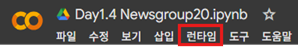

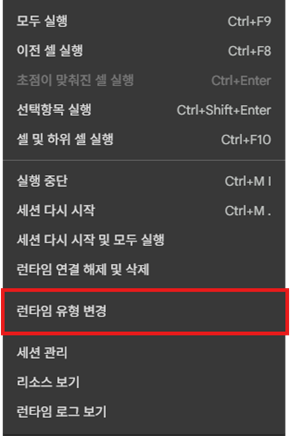

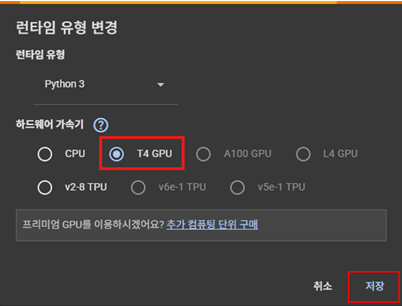

- 필요한 라이브러리 설치 및 호출

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

- GPU 설정

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


- 시드 고정

    - 동일한 실습 환경에서도 모델의 학습 결과가 일관되도록 랜덤성을 최소화
    - 이를 통해 코드 실행 시 매번 동일한 결과를 재현

In [ ]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 1. Fashion MNIST 데이터셋 준비

#### 1.1 Fashion MNIST 데이터셋 불러오기
- `datasets.FashionMNIST` 클래스로 FashionMNIST 데이터셋 불러오기
  - Train 데이터와 Test 데이터를 각각 불러옴

    <details>

    Dataset: 샘플과 레이블 저장

    - `root` 는 학습/테스트 데이터가 저장되는 경로

    - `train` 은 학습용 또는 테스트용 데이터셋 여부를 지정

    - `download=True` 는 root 에 데이터가 없는 경우 인터넷에서 다운로드

    - `transform`은 특징(feature)과 정답(label) 변형(transform)을 지정
    </details>

-  현재 데이터는 <font color="red">이미지</font> → 모델이 입력으로 받기 위해 <font color="red">Tensor</font>로 변형
  - Tensor
    - Pytorch 에서 사용하는 기본적인 데이터 타입
    - 일종의 다차원 행렬
  - `transforms.ToTensor()`
    - ToTensor는 매우 일반적으로 사용되는 데이터 형태 변환 함수로써, 입력 데이터가 이미지 형식인 경우 ToTensor를 사용하여 텐서 형식으로 변환 가능.

In [ ]:
from torchvision import datasets, transforms, utils

# 이미지 데이터를 tensor로 바꿔주는 변환 함수
transform = transforms.ToTensor()

In [ ]:
train_data = datasets.FashionMNIST(
    root      = './data/',
    train     = True,
    download  = True,
    transform = transform
)

test_data = datasets.FashionMNIST(
    root      = './data/',
    train     = False,
    download  = True,
    transform = transform
)

- Dataloader 구축
 - 모델이 학습할 수 있도록 데이터를 적절히 나눠서 순차적으로 입력해주는 역할


In [ ]:
from torch.utils import data

BATCH_SIZE = 64
train_loader = data.DataLoader(
    dataset     = train_data,
    batch_size  = BATCH_SIZE
)
test_loader = data.DataLoader(
    dataset     = test_data,
    batch_size  = BATCH_SIZE
)

#### 1.2 Fashion MNIST 데이터셋 확인

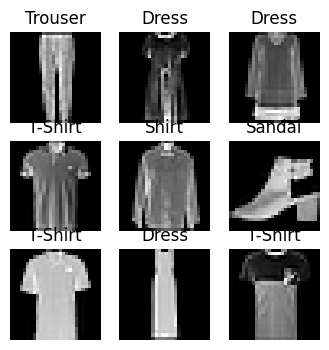

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(4, 4))

cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 2. 모델 구축, 학습, 평가
#### 2.1 모델 구축
  - Neural Network 모델을 정의
  -`__init__` : 모델 생성 시 실행되는 함수, 일반적으로 모델의 layer들을 정의
  -`forward` : 모델에 입력이 들어왔을 때, layer들을 통과시키고 그 결과를 반환하는 함수
  - <font color='red'>Layer의 종류</font>
    - `nn.Linear(input_dim, output_dim)`
      - `input_dim` : 입력되는 데이터의 크기 (차원)
      - `output_dim` : layer를 통과하고 난 뒤 데이터의 크기 (차원)
    - `nn.ReLU()` : ReLU Activation 함수
  - 총 3개의 fully connected layer로 구성된 모델
  - 각각의 fully connected layer는 ReLU Activation 함수를 포함
  - 처음 이미지가 input으로 들어오기 위해서 flatten 과정이 필요

![image.png](https://blog.kakaocdn.net/dn/b5XcJp/btqWUpKHPTL/wy9Z1Kg41sn6Nbqe2IKBMk/img.png)

In [ ]:
# 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256) # (input:28*28(image size), output: 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128) # (input:256, output: 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 10) # (input:128, output: 10(# of class))

    def forward(self, x):
        x = self.flatten(x) # (1,28,28) -> (1,784)
        h1 = self.relu1(self.fc1(x)) # (1,784) -> fc1 -> (1, 256)
        h2 = self.relu2(self.fc2(h1)) # (1,256) -> fc2 -> (1, 128)
        output = self.fc3(h2)  # (1,128) -> fc2 -> (1, 128)

        return output

- `nn.Sequential` : 다수의 layer를 하나로 묶어주는 클래스

In [16]:
# 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        output = self.layers(x)
        return output

# 모델 구축
model = Net().to(device)

#### 2.2 모델 학습 준비
<details>
<summary>상세 정보</summary>

  Loss Function : 모델의 output이 실제 정답과 얼마나 유사한지를 나타내는 함수
  
  두 값이 서로 유사할수록 함수값이 작아지며, 이 함수를 최소화 하는 것이 모델의 최종 학습 목표


  Optimizer : Loss function이 최소화되도록 모델의 Weight를 업데이트 하는 역할

  Learning Rate : 모델이 Weight를 **얼마나** 업데이트 할 지를 결정하는 역할

  Learning Rate Scheduler : 학습이 진행되면서, Learning Rate를 어떻게 바꿀 지 결정
</details>

In [17]:
criterion = nn.CrossEntropyLoss() # Loss Function
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.1)

####2.3 모델 학습 및 평가
<details>
<summary>상세 정보</summary>

학습 : Train 데이터셋으로, 모델의 output이 실제 정답과 유사해지도록, 즉 Loss function이 최소화되도록 Optimizer를 통해 학습

평가 : 학습한 모델이 Test 데이터셋의 라벨(여기서는 토픽)을 얼마나 잘 예측하는지 평가

</details>

- 모델을 학습할 때마다, 모델의 성능을 평가
- 성능 평가 지표
  - Test Loss : 모델이 Test 데이터셋에 있는 뉴스 데이터의 토픽을 얼마나 잘 맞추는지 (낮을수록 좋은 성능)
  - Test Accuracy : 모델이 Test 데이터셋에 있는 전체 뉴스 데이터 중에서 토픽을 잘 맞춘 비율 (높을수록 좋은 성능)

In [18]:
# 모델 학습을 위한 함수
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [19]:
# 모델의 성능을 평가하기 위한 함수
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(dim=1)[1]
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [20]:
# 모델을 학습할 횟수
num_epochs = 10

# 시드 고정
set_seed(14)

# 모델 학습 및 평가
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.8410, Accuracy: 69.28%
[2] Test Loss: 0.6668, Accuracy: 76.38%
[3] Test Loss: 0.5935, Accuracy: 78.92%
[4] Test Loss: 0.5568, Accuracy: 80.21%
[5] Test Loss: 0.5337, Accuracy: 80.83%
[6] Test Loss: 0.5176, Accuracy: 81.51%
[7] Test Loss: 0.5050, Accuracy: 81.94%
[8] Test Loss: 0.4944, Accuracy: 82.32%
[9] Test Loss: 0.4849, Accuracy: 82.57%
[10] Test Loss: 0.4763, Accuracy: 83.07%


- 모델 예측 결과 시각화

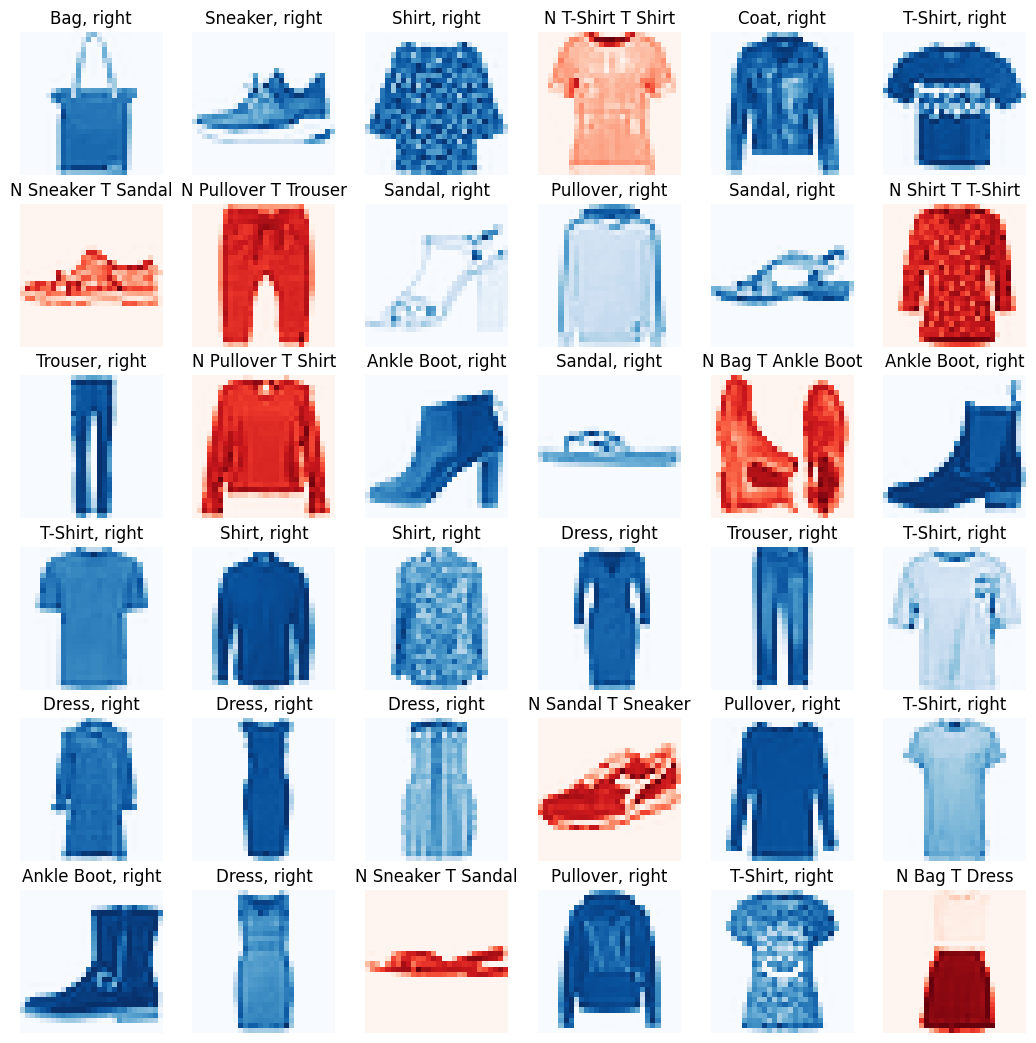

In [ ]:
columns = 6
rows = 6
fig = plt.figure(figsize=(13,13))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device)

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[test_data[data_idx][1]]

    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' T ' +  label)
        cmap = 'Reds'
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')

plt.show()

## 3. 새로운 모델 설계, 학습, 평가



- **Hidden Layer 개수** / **Hidden Layer의 노드 개수 (=Input/Output 차원 수)** / **학습 횟수**를 자유롭게 변형해보면서 성능 변화를 확인

In [ ]:
num_hidden_layers = 3 # Hidden Layer 개수
inout_dims = [[784,256],[256,128],[128,10]] # Hidden Layer의 노드 개수를 결정할 Input과 Output 크기(차원)
num_epochs = 10 # 모델을 학습할 횟수

In [ ]:
class CustomNet(nn.Module):
    def __init__(self, num_hidden_layers, inout_dims):
        super(CustomNet, self).__init__()
        layers = [nn.Flatten()]  # 먼저 flatten 추가

        for i in range(num_hidden_layers):
            in_dim, out_dim = inout_dims[i] # ex : inout_dims[0] = [784,256], in_dim=784 , out_dim = 256
            layers.append(nn.Linear(in_dim, out_dim)) # ex : nn.Linear(784,256)
            if i != num_hidden_layers - 1: # 마지막 hidden layer를 제외하고 ReLU를 추가
                layers.append(nn.ReLU())

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# 모델 구축
custom_model = CustomNet(num_hidden_layers, inout_dims).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() # Loss Function
optimizer = optim.SGD(custom_model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.1)

# 모델 학습을 위한 함수
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# 모델의 성능을 평가하기 위한 함수
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(dim=1)[1]
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# 시드 고정
set_seed(14)

# 모델 학습 및 평가
for epoch in range(1, num_epochs + 1):
    train(custom_model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(custom_model, test_loader)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

In [ ]:
# 모델 결과 시각화
columns = 6
rows = 6
fig = plt.figure(figsize=(13,13))

custom_model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device)

    output = custom_model(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[test_data[data_idx][1]]

    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' T ' +  label)
        cmap = 'Reds'
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')

plt.show()